## Import modules and define functions

In [1]:
# This file is part of CbM (https://github.com/ec-jrc/cbm).
# Author    : WIRNHARDT Csaba
# Credits   : GTCAP Team
# Copyright : 2021 European Commission, Joint Research Centre
# License   : 3-Clause BSD


import requests
import pandas as pd
import datetime
import numpy as np
import time
import psycopg2
import json
import os
from matplotlib import pyplot
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
import calendar
import sys

def get_s2_data_from_restful(ms, year, fid):
    # Set you RESTful API Credentials
    api_user = ''
    api_pass = ''
    api_host = 'http://185.178.85.7/'

    url = api_host + "query/parcelTimeSeries?aoi=" + ms + "&year=" + str(year) + "&pid=" + str(fid) + "&tstype=s2&scl=True&ref=True"
    print(url)
    response = requests.get(url, auth=(api_user, api_pass))
    df = pd.read_json(response.text)
    return df

def get_cloudyness(cloud_stats, cloud_categories):
    is_cloudy = False
    cloudy_pixels = 0
    total_pixels = 0
    keys = [*cloud_stats]
    for key in keys:
        if int(key) in cloud_categories:
            is_cloudy = True
            cloudy_pixels += cloud_stats[key]
            total_pixels += cloud_stats[key]
        else:
            total_pixels += cloud_stats[key]
    if total_pixels > 0:
        cloud_percent = int(round(cloudy_pixels / total_pixels *100,0))
    else:
        cloud_percent = None
    return is_cloudy, cloud_percent

def get_utm_number_from_reference(ref):
    return int(ref.split('_')[5][1:3])

def calculate_ndvi_std_from_band_mean_and_std(red_mean,nir_mean,red_std,nir_std):
    ndvi_std = 2 * np.sqrt((nir_mean*red_std)**2 +
                           (red_mean*nir_std)**2) / (nir_mean + red_mean)**2
    return ndvi_std

def calculate_ndvi_and_cloud_percent_for_the_parcel(df_ext, cloud_categories):
    # we make a copy first of the dataframe passed to this function to avoid changing the original
    # dataframe
    df = df_ext.copy()
    # Convert the epoch timestamp to a datetime
    df['date_part']=df['date_part'].map(lambda e: datetime.datetime.fromtimestamp(e))
    df['cloud_pct'] = df['hist'].apply(lambda s: get_cloudyness(s, cloud_categories)[1]) 
    bands = ['B04', 'B08']
    # Treat each band separately. 
    df0 = df[df['band']==bands[0]][['date_part', 'mean', 'count', 'std', 'cloud_pct', 'reference']]
    df1 = df[df['band']==bands[1]][['date_part', 'mean', 'count', 'std', 'cloud_pct', 'reference']]
    # Merge back into one DataFrame based on reference that should be unique
    dff = pd.merge(df0, df1, on = 'reference', suffixes = (bands[0], bands[1]))
    dff['ndvi'] = (dff[f"mean{bands[1]}"]-dff[f"mean{bands[0]}"])/(dff[f"mean{bands[1]}"]+dff[f"mean{bands[0]}"])
    dff['utm_number'] = dff['reference'].apply(lambda s: get_utm_number_from_reference(s))
    
    dff['ndvi_std'] = dff.apply(lambda x: calculate_ndvi_std_from_band_mean_and_std(x.meanB04,x.meanB08,x.stdB04,x.stdB08), axis=1)
    
    pd.set_option('precision', 3)
    pd.set_eng_float_format(accuracy=3)
    return dff

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month  

def display_ndvi_profiles(x_start_date, x_end_date, ndvi_profile, parcel_id, crop, plot_title, 
                                             output_graph_folder, logfile, jpg_filename,
                                             add_error_bars = False, save_figures = False, fixed_date_range = False):                                         
    y_tick_spacing = 0.1

    if not os.path.exists(output_graph_folder):
        os.makedirs(output_graph_folder)

    # plot the time series
    ax0 = pyplot.gca()
    
# pid 	acq_date 	ndvi_mean 	ndvi_std 	tot_pixel 	crop    

    if not ndvi_profile.empty:
        if add_error_bars:
            ndvi_profile.plot(kind='line', marker='+', x='dateB08', y='ndvi', label='S2 NDVI', yerr='ndvi_std', color = 'blue', ax=ax0, 
                              capsize=4, ecolor='grey', barsabove = 'True')  
        else:
            ndvi_profile.plot(kind='line', marker='+', x='dateB08', y='ndvi', label='S2 NDVI', color = 'blue', ax=ax0)

    # format the graph a little bit
    pyplot.ylabel('NDVI')
    pyplot.title(plot_title + ", Parcel id: " + str(parcel_id) + " " + crop)
    ax0.set_ylim([0,1])
    ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
         
    ax0.xaxis.grid() # horizontal lines
    ax0.yaxis.grid() # vertical lines

    fig = pyplot.gcf()
    fig.autofmt_xdate() # Rotation
    fig_size_x = 13
    fig_size_y = 7
    fig.set_size_inches(fig_size_x, fig_size_y)
    
    if fixed_date_range:
        x_start_date_date = datetime.datetime.strptime(x_start_date, '%Y-%m-%d').date()
        x_end_date_date = datetime.datetime.strptime(x_end_date, '%Y-%m-%d').date()
        min_month = x_start_date_date.month
        min_year = x_start_date_date.year
        max_month = x_end_date_date.month
        max_year = x_end_date_date.year
        number_of_months = diff_month(x_end_date_date, x_start_date_date) + 1
    else:
        min_month = min(ndvi_profile['acq_date']).date().month
        min_year = min(ndvi_profile['acq_date']).date().year
        max_month = max(ndvi_profile['acq_date']).date().month
        max_year = max(ndvi_profile['acq_date']).date().year
        number_of_months = diff_month(max(ndvi_profile['acq_date']).date(), min(ndvi_profile['acq_date']).date()) + 1
        
    ax0.set_xlim([datetime.date(min_year, min_month, 1), 
                  datetime.date(max_year, max_month,
                                calendar.monthrange(max_year, max_month)[1])])
    
    min_year_month = str(min_year) + ('0' + str(min_month))[-2:]
#     start_x = 0.045
    step_x = 1/number_of_months
    start_x = step_x/2 # positions are in graph coordinate system between 0 and 1
                                     # so first year_month label is at half the size of the widht of
                                     # one month
    loc_y = 0.915
    
    current_year_month_text = get_current_list_of_months(min_year_month, number_of_months)
    
    for current_year_month_index in range (0, number_of_months):
        t = current_year_month_text[current_year_month_index]
        loc_x = start_x + (current_year_month_index) * step_x
        ax0.text(loc_x, loc_y, t, verticalalignment='bottom', horizontalalignment='center', transform=ax0.transAxes,
                color='blue', fontsize=13)

    ax0.yaxis.set_major_locator(ticker.MultipleLocator(y_tick_spacing))

    # save the figure to a jpg file
    if save_figures:
        fig.savefig(output_graph_folder + '/' + jpg_filename ) 
        pyplot.close(fig)    
def get_clean_cloudfree_unique_s2_data(ts):
    if not ts.empty:
        ts_clean = calculate_ndvi_and_cloud_percent_for_the_parcel(ts, cloud_categories)
        ts_clean['dateB04'] = ts_clean['date_partB04'].apply(lambda s: s.date())  
        ts_clean['dateB08'] = ts_clean['date_partB08'].apply(lambda s: s.date())  
        ts_clean = ts_clean.sort_values(by=['dateB04'])

    #                 The idea here is that we consider a date cloudfree only if in any UTM tile
    #                 it is cloudfree - this is a conservative approach: if after the processing 
    #                 the image in any UTM there is a chance that it is cloudy we leave it out
        # first we calculate the maximum of the could percent for each date
        ts_clean_max_cc = ts_clean.groupby(['dateB04']).max()

        # then we select the dates where the max of the cloud percent is still 0
        # we create a list of these absolutely cloudfree dates
        cloudfree_dates = ts_clean_max_cc[ts_clean_max_cc['cloud_pctB04']==0].index.tolist()

        # then we create a dataframe with leaving in it only the cloudfree dates
        ts_clean_cloudfree = ts_clean[ts_clean['dateB04'].isin(cloudfree_dates)]

        # there can be still 2 calculated values per date (eg both UTM are cloudfree)
        # we calculate the max of NDVI and pixel count
        ts_clean_cloudfree_unique = ts_clean_cloudfree.groupby(['dateB04']).max()
        return ts_clean_cloudfree_unique
    
def get_current_list_of_months(first_year_month, number_of_year_months):
    textstrs_tuples = [
                       ("201701", "2017\nJAN"),
                       ("201702", "2017\nFEB"),
                       ("201703", "2017\nMAR"),
                       ("201704", "2017\nAPR"),
                       ("201705", "2017\nMAY"),
                       ("201706", "2017\nJUN"),
                       ("201707", "2017\nJUL"),
                       ("201708", "2017\nAUG"),
                       ("201709", "2017\nSEP"),
                       ("201710", "2017\nOCT"),
                       ("201711", "2017\nNOV"),
                       ("201712", "2017\nDEC"),
                       ("201801", "2018\nJAN"),
                       ("201802", "2018\nFEB"),
                       ("201803", "2018\nMAR"),
                       ("201804", "2018\nAPR"),
                       ("201805", "2018\nMAY"),
                       ("201806", "2018\nJUN"),
                       ("201807", "2018\nJUL"),
                       ("201808", "2018\nAUG"),
                       ("201809", "2018\nSEP"),
                       ("201810", "2018\nOCT"),
                       ("201811", "2018\nNOV"),
                       ("201812", "2018\nDEC"),
                       ("201901", "2019\nJAN"),
                       ("201902", "2019\nFEB"),
                       ("201903", "2019\nMAR"),
                       ("201904", "2019\nAPR"),
                       ("201905", "2019\nMAY"),
                       ("201906", "2019\nJUN"),
                       ("201907", "2019\nJUL"),
                       ("201908", "2019\nAUG"),
                       ("201909", "2019\nSEP"),
                       ("201910", "2019\nOCT"),
                       ("201911", "2019\nNOV"),
                       ("201912", "2019\nDEC"),
                       ("202001", "2020\nJAN"),
                       ("202002", "2020\nFEB"),
                       ("202003", "2020\nMAR"),
                       ("202004", "2020\nAPR"),
                       ("202005", "2020\nMAY"),
                       ("202006", "2020\nJUN"),
                       ("202007", "2020\nJUL"),
                       ("202008", "2020\nAUG"),
                       ("202009", "2020\nSEP"),
                       ("202010", "2020\nOCT"),
                       ("202011", "2020\nNOV"),
                       ("202012", "2020\nDEC"),
                       ("202101", "2021\nJAN"),
                       ("202102", "2021\nFEB"),
                       ("202103", "2021\nMAR"),
                       ("202104", "2021\nAPR"),
                       ("202105", "2021\nMAY"),
                       ("202106", "2021\nJUN"),
                       ("202107", "2021\nJUL"),
                       ("202108", "2021\nAUG"),
                       ("202109", "2021\nSEP"),
                       ("202110", "2021\nOCT"),
                       ("202111", "2021\nNOV"),
                       ("202112", "2021\nDEC"),                       
                      ]

    # find the index of the first occurrence of first_year_month in textstrs_tuples
    # and return the rest secend elements of the tuples of the list

    i = 0
    first_year_month_index = i
    for textstrs_tuple in textstrs_tuples:
        if first_year_month == textstrs_tuple[0]:
            first_year_month_index = i
        i+=1

    current_textstrs = []
    for i in range(first_year_month_index, first_year_month_index + number_of_year_months):
        current_textstrs.append(textstrs_tuples[i][1])

    return current_textstrs    


### Extract profile from database with RESTful service

In [2]:
fid = 123
ms = ""
year = 2020

cloud_categories = [3,8,9,10,11] # 10 is thin cirrus

ts = get_s2_data_from_restful(ms, year, fid)
ts_clean_cloudfree_unique = get_clean_cloudfree_unique_s2_data(ts)


http://185.178.85.7/query/parcelTimeSeries?aoi=bewa&year=2020&pid=58950&tstype=s2&scl=True&ref=True


### Plot graph

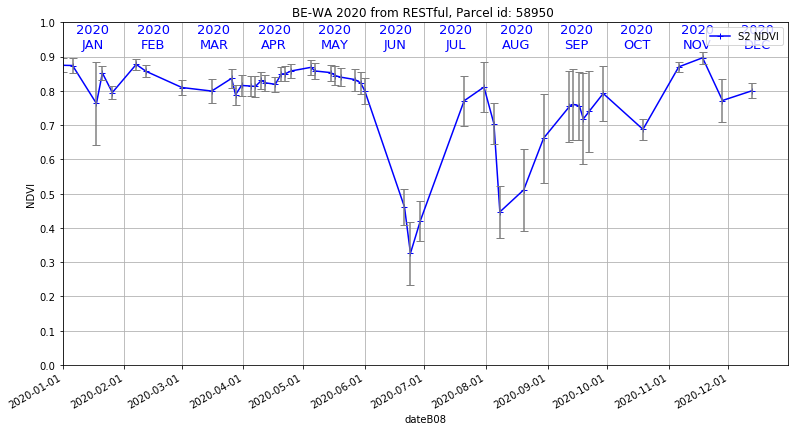

In [4]:
output_graph_folder = "temp" + ms.upper() + "/mowing_detection/ndvi_graphs"
logfile = "ndvi_test.log"

# df_diff = pd.DataFrame()
add_error_bars = True
save_figures = False
fixed_date_range = True
x_start_date = "2020-01-01"
x_end_date = "2020-12-31"

plot_title = ms.upper() + " " + str(year) + " from RESTful"
# pid 	acq_date 	ndvi_mean 	ndvi_std 	tot_pixel 	crop
ndvi_profile_filtered = ts_clean_cloudfree_unique

if not ndvi_profile_filtered.empty:
    # sort by date
    ndvi_profile_filtered = ndvi_profile_filtered.sort_values(by=['dateB08'])
    # print(ndvi_profile_filtered)

    # select the parcel from the geopandas dataframe based on the fid_int column
    # and get real parcel id and crop name and other attributes if needed
    jpg_filename = str(fid) + ".jpg"
    crop = ""
    parcel_id = str(fid)
    
    display_ndvi_profiles(x_start_date, x_end_date, ndvi_profile_filtered, parcel_id, crop, plot_title, 
                                                 output_graph_folder, logfile, jpg_filename,
                                                 add_error_bars, save_figures, fixed_date_range)
